# ROS3 VFD Log Analysis Dashboard

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
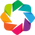

In [1]:
from dataclasses import dataclass
import io
import re
import numpy as np
from bokeh.models import HoverTool
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension()

## Log Parser

The class that represents information of one HTTP range GET request:

In [2]:
@dataclass(frozen=True)
class ByteRange:
    start: int
    end: int
    filesize: int

    def __post_init__(self):
        if self.start < 0 or self.end <= 0 or self.filesize <= 0:
            raise ValueError('Start, end, and file size values must be positive integers')
        elif self.end > self.filesize:
            raise ValueError('End value must be smaller or equal to file size')
        elif self.start > self.end:
            raise ValueError('Start value must be smaller or equal to end value')

    @property
    def size(self):
        return self.end - self.start + 1

    def __len__(self):
        return self.size

Log file parser:

In [3]:
def parse_ros3vfd_log(content: bytes) -> list[ByteRange]:
    head_line = re.compile('HEAD: Bytes 0 - ')
    fsize_line = re.compile('(FILESIZE| -- size): (?P<size>[0-9]+)')
    range_line = re.compile('GET: Bytes (?P<start>[0-9]+) - (?P<end>[0-9]+), Request Size: (?P<size>[0-9]+)')

    ranges = list()
    with io.TextIOWrapper(io.BytesIO(content)) as logtxt:
        for line in logtxt:
            if head_line.match(line):
                break
        else:
            raise RuntimeError('HEAD line not found in the log file')

        for line in logtxt:
            match = fsize_line.match(line)
            if match:
                fsize = int(match.group('size'))
                break
        else:
            raise RuntimeError('FILESIZE line not found in the log file')

        for line in logtxt:
            match = range_line.search(line)
            if match:
                range = ByteRange(start=int(match.group('start')), 
                                  end=int(match.group('end')),
                                  filesize=fsize)
                if range.size != int(match.group('size')):
                    raise ValueError(f'Reported size different for {match.group()}')
                ranges.append(range)
                
    return ranges

In [ ]:
def parse_fsspec_log(content: bytes) -> list[ByteRange]:
    """
    This method only parses fsspec logs that have a FileSize: attached to them.
    """
    head_line  = re.compile('<File-like object S3FileSystem, .*?>\s*(read: 0 - \d+)')
    fsize_line = re.compile('FileSize: (\d+)')
    range_line = re.compile('<File-like object S3FileSystem, .*?>\s* read: (?P<start>[0-9]+) - (?P<end>[0-9]+)')

    ranges = list()
    with io.TextIOWrapper(io.BytesIO(content)) as logtxt:
        for line in logtxt:
            if head_line.match(line):
                break
        else:
            raise RuntimeError('HEAD line not found in the log file')

        for line in logtxt:
            match = fsize_line.match(line)
            if match:
                fsize = int(match.group(1))
                break
        else:
            raise RuntimeError('FILESIZE line not found in the log file')
            
        logtxt.seek(0)
        for line in logtxt:
            match = range_line.match(line)
            if match:
                start=int(match.group(1))
                end=int(match.group(2))
                rsize=end-start+1
                range = ByteRange(start=int(match.group(1)), 
                                  end=int(match.group(2)),
                                  filesize=fsize)
                
                ranges.append(range)

    return ranges

## Dashboard

Function for generating log stats and plots:

In [4]:
def plot_ros3vfd_log(from_file):
    if from_file is None:
        return
    elif len(from_file) == 0:
        return [pn.pane.Alert('ros3vfd log file empty.', alert_type='danger')]
    logging_schema = "fsspec"
    try:
        ranges = parse_fsspec_log(from_file)
    except Exception as fsspec_e:
        try: 
            ranges = parse_ros3vfd_log(from_file)
            logging_schema = "ros3vfd"
        except Exception as ros3_e:  
            return [pn.pane.Alert(f'Error: ROS3 {str(ros3_e)}', alert_type='danger')]
    start = np.fromiter([r.start for r in ranges], dtype=np.uint64)
    end = np.fromiter([r.end for r in ranges], dtype=np.uint64)
    req_no = np.arange(len(ranges)) + 1
    sizes = np.fromiter([r.size for r in ranges], np.uint64)
    info = pn.pane.Markdown(f"""
# {logging_schema} Log Information

Log size: {len(from_file):,} bytes

HDF5 file size: {ranges[0].filesize:,} bytes

Number of range _GET_ requests: {len(ranges):,}

Overall range _GET_ requests stats:

* Smallest: {np.min(sizes):,} bytes<br/>
* Median: {int(np.median(sizes)):,} bytes<br/>
* Largest: {np.max(sizes):,} bytes

Maximum file byte read: {end.max():,}

Total of file content read: {sizes.sum():,} bytes

Percentage of content read to file size: {100 * (sizes.sum() / ranges[0].filesize) :.2f} %
""")
    data = dict(start=start, end=end, start_event=req_no, end_event=req_no)
    max_offset_range = min(16_000_000, np.max(end))
    req_range = np.where(end <= max_offset_range)[0]
    if req_range.size == 0:
        max_req_range = req_no[-1]
    else:
        max_req_range = req_no[np.where(end <= max_offset_range)[0][-1]] + 1
    ros3plt = hv.Segments(
        data, 
        [
            hv.Dimension('start', label='File offset', range=(0, max_offset_range)),
            hv.Dimension('start_event', label='Req. No.', range=(0, max_req_range)), 
            'end', 
            'end_event'
        ]
    )
    hvrtip = HoverTool(
        tooltips = [
            ('req no', '@start_event'),
            ('start byte', '@start'),
            ('end byte', '@end')
        ]
    )
    ros3plt.opts(width=700, height=600, invert_axes=True, color='blue', 
                 line_width=3, tools=[hvrtip])
    size_hist = hv.Histogram(np.histogram(sizes, bins=512))
    size_hist.opts(color='blue', line_color=None, tools=['hover'],
                   xlabel='Size (bytes)', ylabel='Number of requests')
    
    return [pn.Row(info, size_hist), ros3plt]

### Dashboard Components

In [5]:
log_file = pn.widgets.FileInput()
upld_form = pn.Row(
    pn.pane.Markdown('Please select a ros3vfd or fsspec log file (limit 10MB):'),
    log_file
)
res = pn.Column()
app = pn.WidgetBox(upld_form, res)

Callback function for interactive log processing invocation:

In [6]:
def callback(value):
    res.objects = plot_ros3vfd_log(value)

Register callback with the appropriate dashboard object:

In [7]:
log_file.param.watch_values(callback, ['value']);

Run the dashboard:

In [8]:
app.servable()

WidgetBox
    [0] Row
        [0] Markdown(str)
        [1] FileInput()
    [1] Column()